In [1]:
utf8::utf8_print('\U0001f6a7 work in progress \U0001f6a7')

[1] "🚧​ work in progress 🚧​"


# Study of the synonymous mutations

Created: **19/07/18**  
Last modified: **17/08/18**

**Goal:** this study will focus only on the `synonymous_SNV` mutations, trying first to filter the non-somatic synonymous mutations and then to study the reccurent synonymous mutations. This notebook follows the methodology of the `coding_mutations_analysis.ipynb` notebook.  
This notebook is divided in two parts:
* **1. The `type` feature: coding_somatic vs synonymous**: introduce a new feature to class the mutations as coding_somatic or synonymous. The idea is to filter the set of synonymous mutations by comparing their parameters to a set of known somatic mutations parameters.
* **2. The `mut_key` feature: study of reccurent mutations**: study the reccurence of synonymous mutations.

**Refs:**
* `coding_mutations_analysis.ipynb`

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-type-feature:-coding_somatic-vs-synonymous" data-toc-modified-id="The-type-feature:-coding_somatic-vs-synonymous-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The <code>type</code> feature: coding_somatic vs synonymous</a></span><ul class="toc-item"><li><span><a href="#Creating-the-feature" data-toc-modified-id="Creating-the-feature-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating the feature</a></span></li><li><span><a href="#Comparison-of-the-frequency_in_normals,-t_vaf-and-strand_ratio" data-toc-modified-id="Comparison-of-the-frequency_in_normals,-t_vaf-and-strand_ratio-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparison of the <code>frequency_in_normals</code>, <code>t_vaf</code> and <code>strand_ratio</code></a></span></li><li><span><a href="#Comparison-of-Kaviar_AF" data-toc-modified-id="Comparison-of-Kaviar_AF-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Comparison of <code>Kaviar_AF</code></a></span></li><li><span><a href="#Comparison-of-cosmic_count" data-toc-modified-id="Comparison-of-cosmic_count-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Comparison of <code>cosmic_count</code></a></span></li></ul></li><li><span><a href="#The-mut_key-feature:-study-of-reccurent-mutations" data-toc-modified-id="The-mut_key-feature:-study-of-reccurent-mutations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The <code>mut_key</code> feature: study of reccurent mutations</a></span><ul class="toc-item"><li><span><a href="#Identify-the-reccurent-mutations" data-toc-modified-id="Identify-the-reccurent-mutations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Identify the reccurent mutations</a></span></li><li><span><a href="#Sudy-the-reccurent-mutations-genes" data-toc-modified-id="Sudy-the-reccurent-mutations-genes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sudy the reccurent mutations genes</a></span></li><li><span><a href="#Study-the-outliers" data-toc-modified-id="Study-the-outliers-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Study the outliers</a></span></li></ul></li></ul></div>

***

In [2]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

In [3]:
impact <- read.table("../../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
impact <- add_features("../../../data/", impact, annotations = TRUE)

In [4]:
colnames(impact)

[1] "Hugo_Symbol"          "Chromosome"           "Start_Position"      
 [4] "End_Position"         "Consequence"          "Variant_Type"        
 [7] "Reference_Allele"     "Tumor_Seq_Allele2"    "Tumor_Sample_Barcode"
[10] "cDNA_change"          "HGVSp_Short"          "t_depth"             
[13] "t_vaf"                "t_alt_count"          "n_depth"             
[16] "n_vaf"                "n_alt_count"          "t_ref_plus_count"    
[19] "t_ref_neg_count"      "t_alt_plus_count"     "t_alt_neg_count"     
[22] "confidence_class"     "sample_coverage"      "mut_key"             
[25] "sample_mut_key"       "frequency_in_normals" "Kaviar_AF"           
[28] "cosmic_count"

## The `type` feature: coding_somatic vs synonymous

The `synonymous_SNV` mutations have automatically been classified as `UNKNOWN` so we don't know which one are somatic or non-somatic mutations. However, the coding mutations have been curated, and we know which one of them are somatic. Thus, we can take the somatic coding mutations as a reference of mutations that are somatic. For example, comparing the `frequency_in_normals` for `synonymous_SNV` mutations and somatic coding mutations could reveal a difference and help us to filter the `synonymous_SNV` mutations that are somatic from the one that are non-somatic.  

Unfortunately, this study will show that the `frequency_in_normals`, `t_vaf` and `strand_bias` features won't be relevant to filter the `synonymous_SNV` mutations. However, the `Kaviar_AF` feature could help us!

### Creating the feature

We create a new feature `type`:
* A mutation has `type = synonymous` if `Consequence = synonymous_SNV`
* A mutation has `type = coding_somatic` if it is a coding mutation and `confidence_class = AUTO_OK | MANUAL_OK`.

In [5]:
impact <- impact[(impact$Consequence == "synonymous_SNV") |
                 (impact$Consequence != "synonymous_SNV" & (impact$confidence_class == "AUTO_OK" |
                                                            impact$confidence_class == "MANUAL_OK")),]
impact$type <- "coding_somatic"
impact$type[(impact$Consequence == "synonymous_SNV")] <- "synonymous"

addmargins(table(impact$type, impact$confidence_class), margin = 2)
100 * nrow(impact[impact$type == "synonymous",]) / nrow(impact) # percentage of synonymous mutations

AUTO_OK MANUAL_OK UNKNOWN Sum   
  coding_somatic 180733  6335          0   187068
  synonymous          0     0      50005    50005

[1] 21.09266

The dataset is unbalanced with 50,010 synonymous mutations ($21.1\%$ of the samples) vs 187,098 somatic mutations ($78.9\%$ of the samples).

### Comparison of the `frequency_in_normals`, `t_vaf` and `strand_ratio`

We create the `strand_ratio` feature:

In [6]:
impact$strand_ratio <- pmin(impact$t_alt_neg_count, impact$t_alt_plus_count) /
                       pmax(impact$t_alt_neg_count, impact$t_alt_plus_count)

Distribution of `frequency_in_normals`, `tvaf` and `strand_ratio` for the coding vs synonymous `type` (warning the first and last plot have a sqrt x and sqrt y scale):

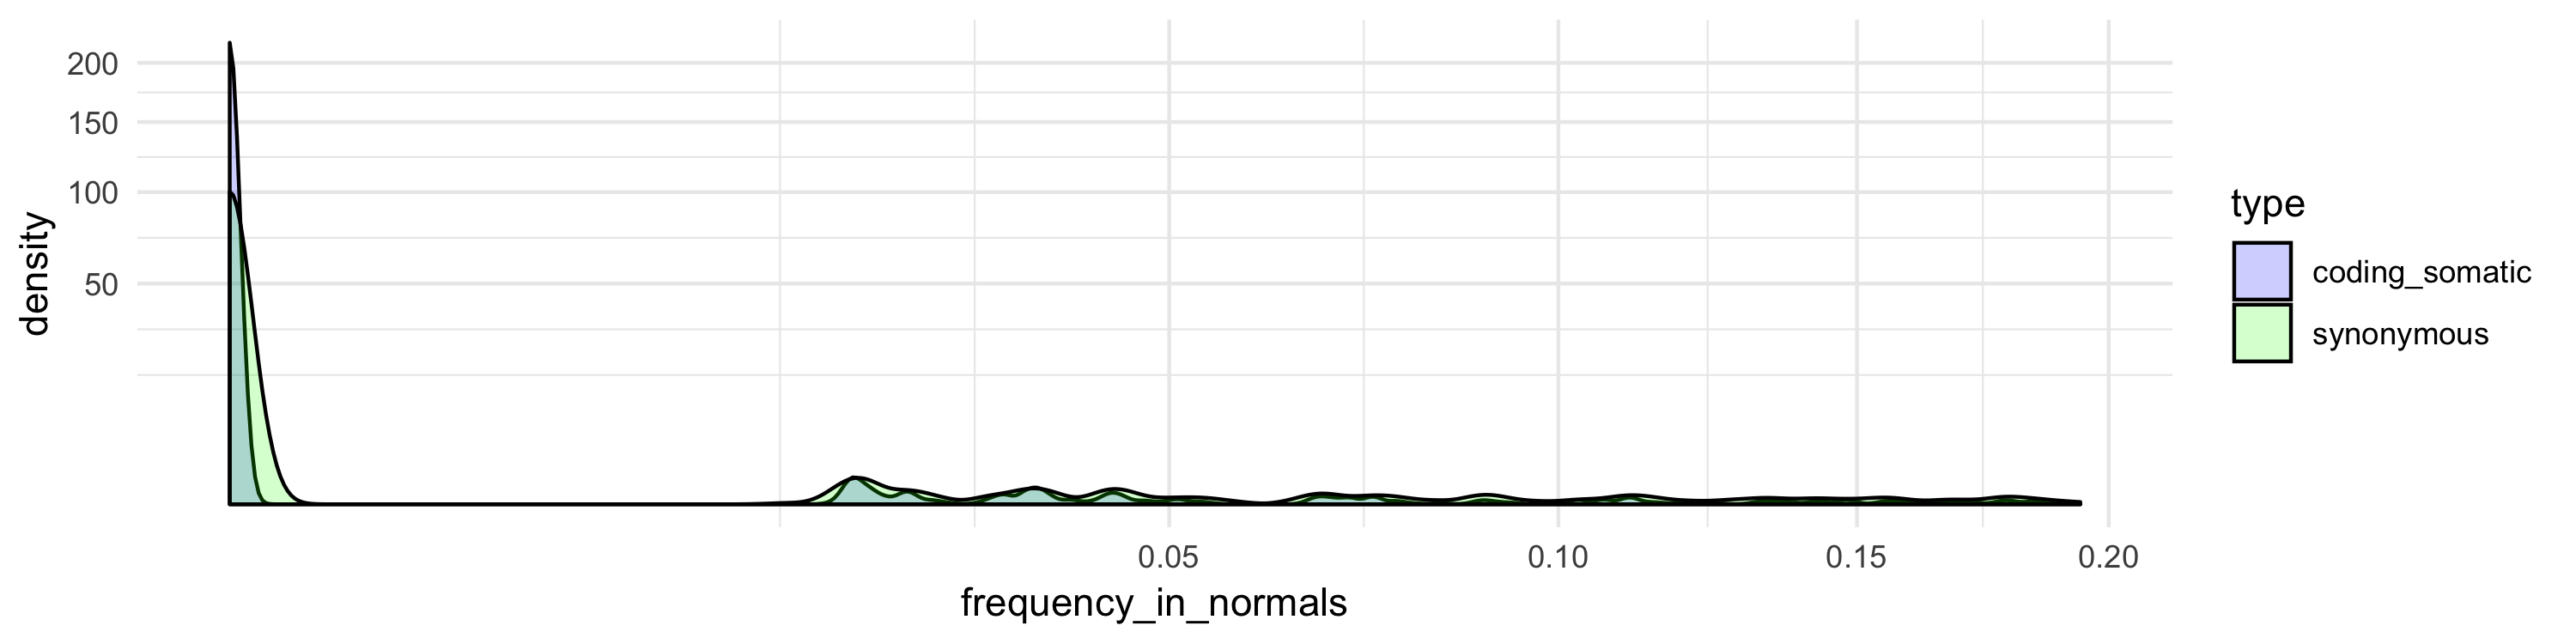

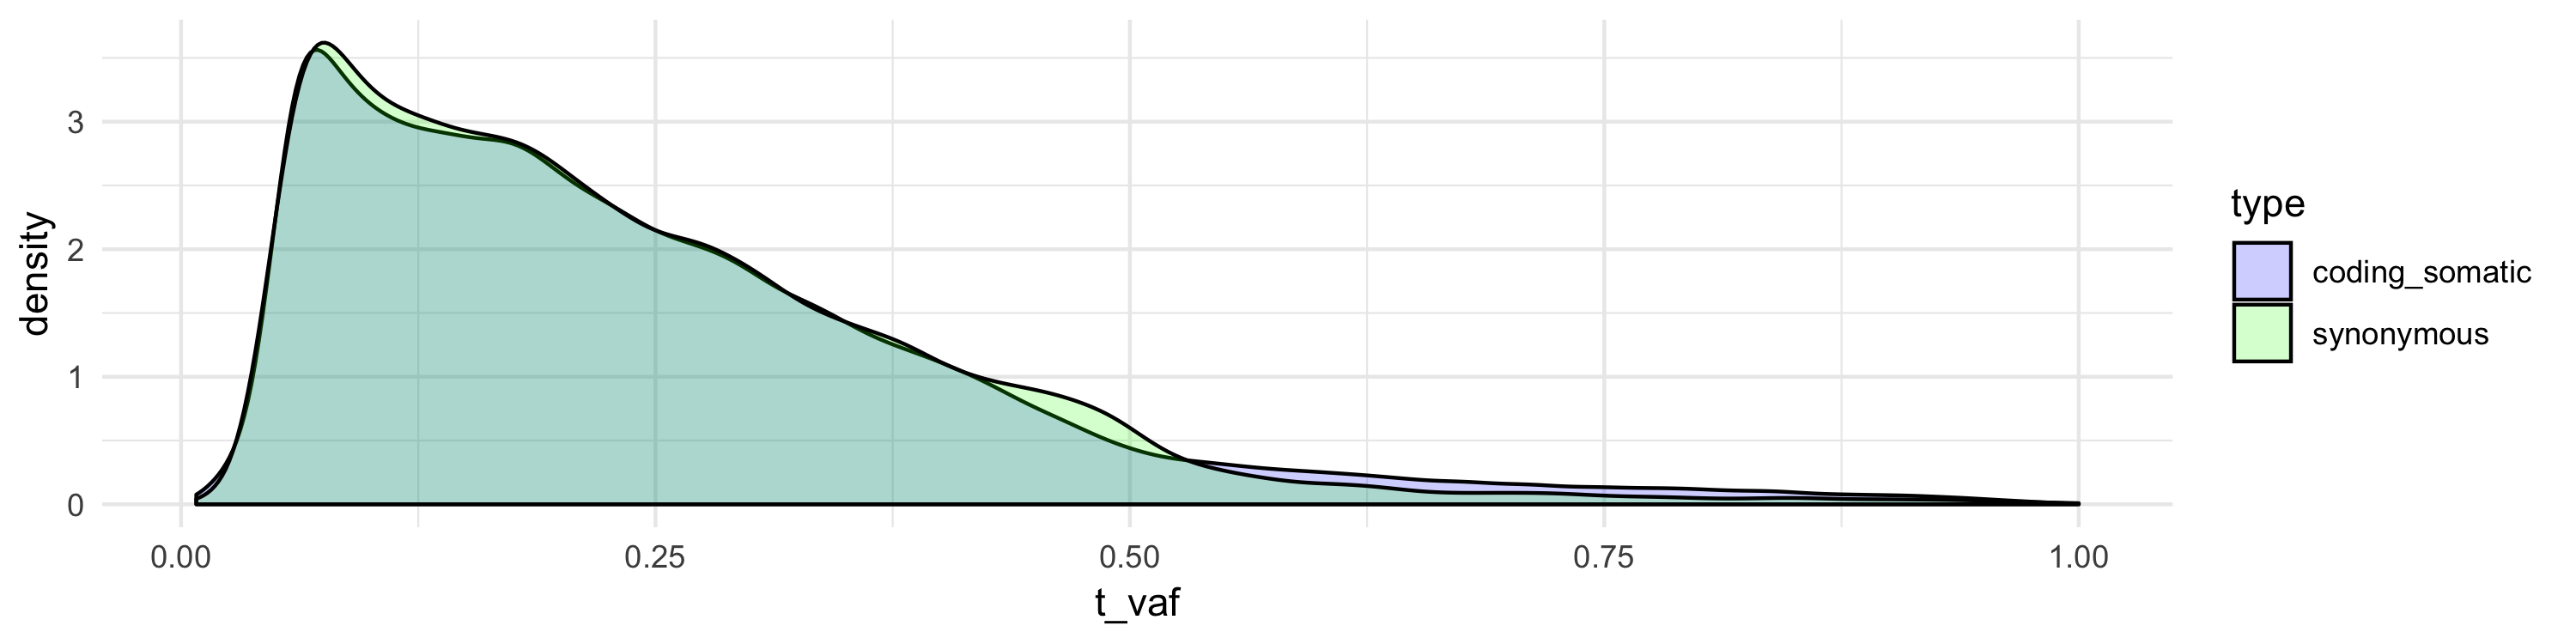

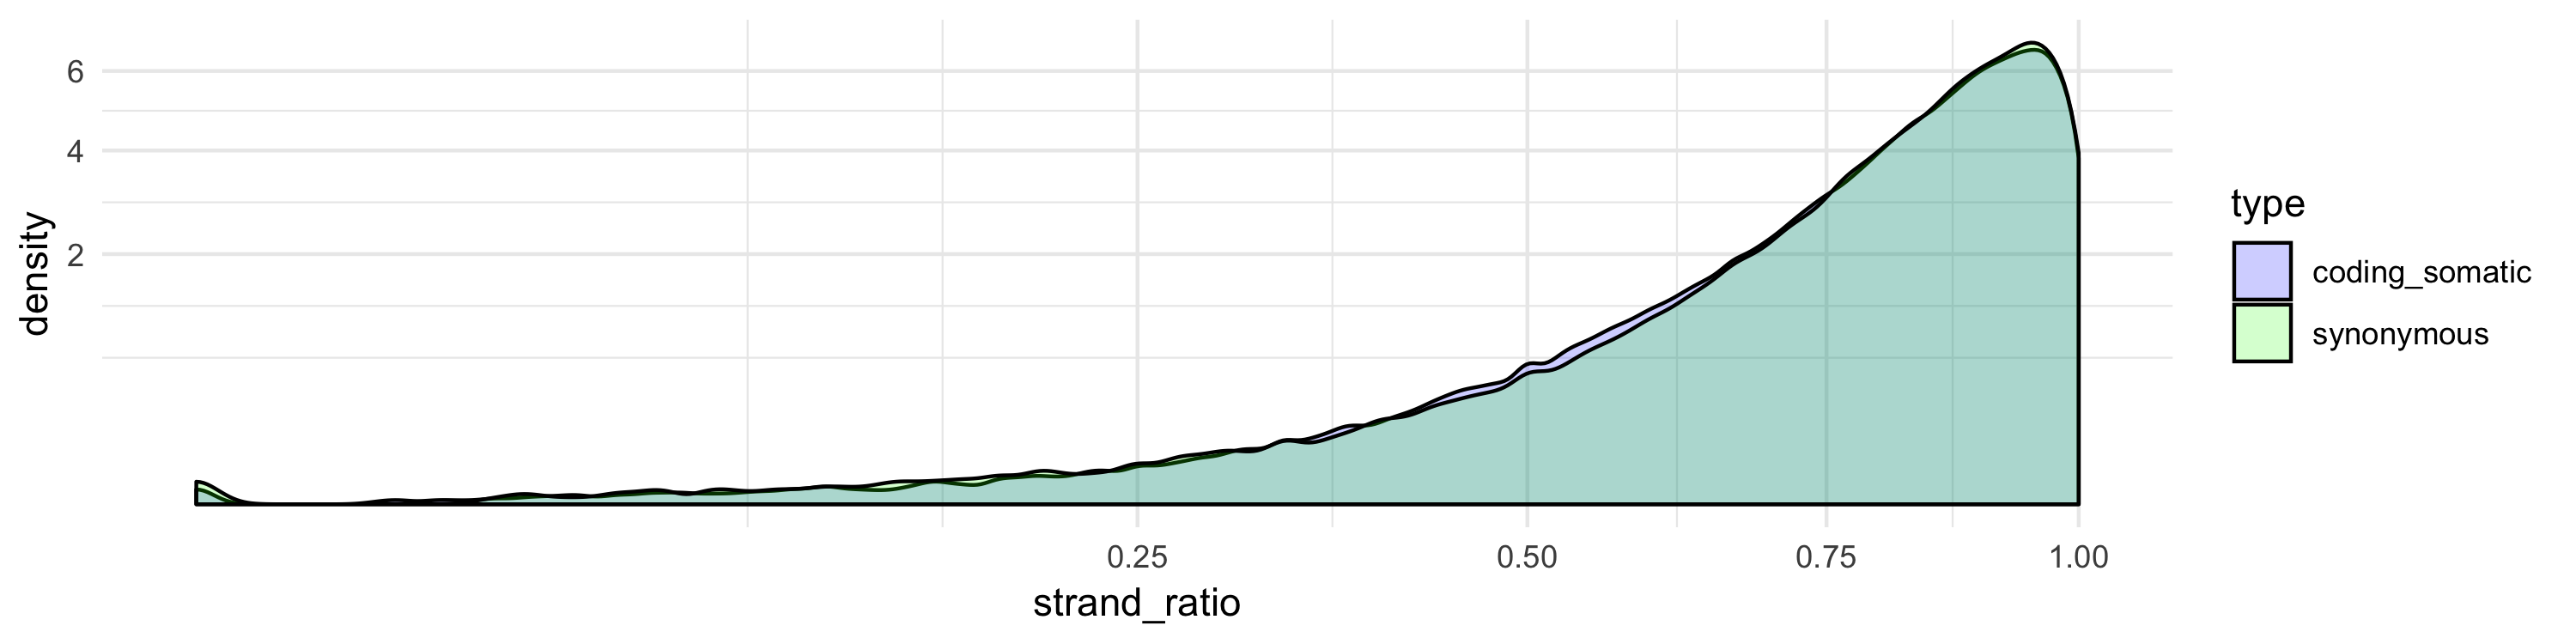

In [7]:
plot_density(impact, "frequency_in_normals", "type", height = 2.5) + scale_x_sqrt() + scale_y_sqrt()
plot_density(impact, "t_vaf", "type", height = 2.5)
plot_density(impact, "strand_ratio", "type", height = 2.5) + scale_x_sqrt() + scale_y_sqrt()

The distributions are almost identical in every plot. Wee see a little bump at `t_vaf` $\approx 0.5$ for the synonymous mutations, most likely the germline part of it but it is really not pronounced.

Below is an attempt to plot the `strand_ratio` vs the `t_vaf` to separate the germline (`t_vaf` $\approx 0.5$ and high `strand_ratio`) from the artefact (low `t_vaf` and low `strand_ratio`), but nothing really discriminant was found.

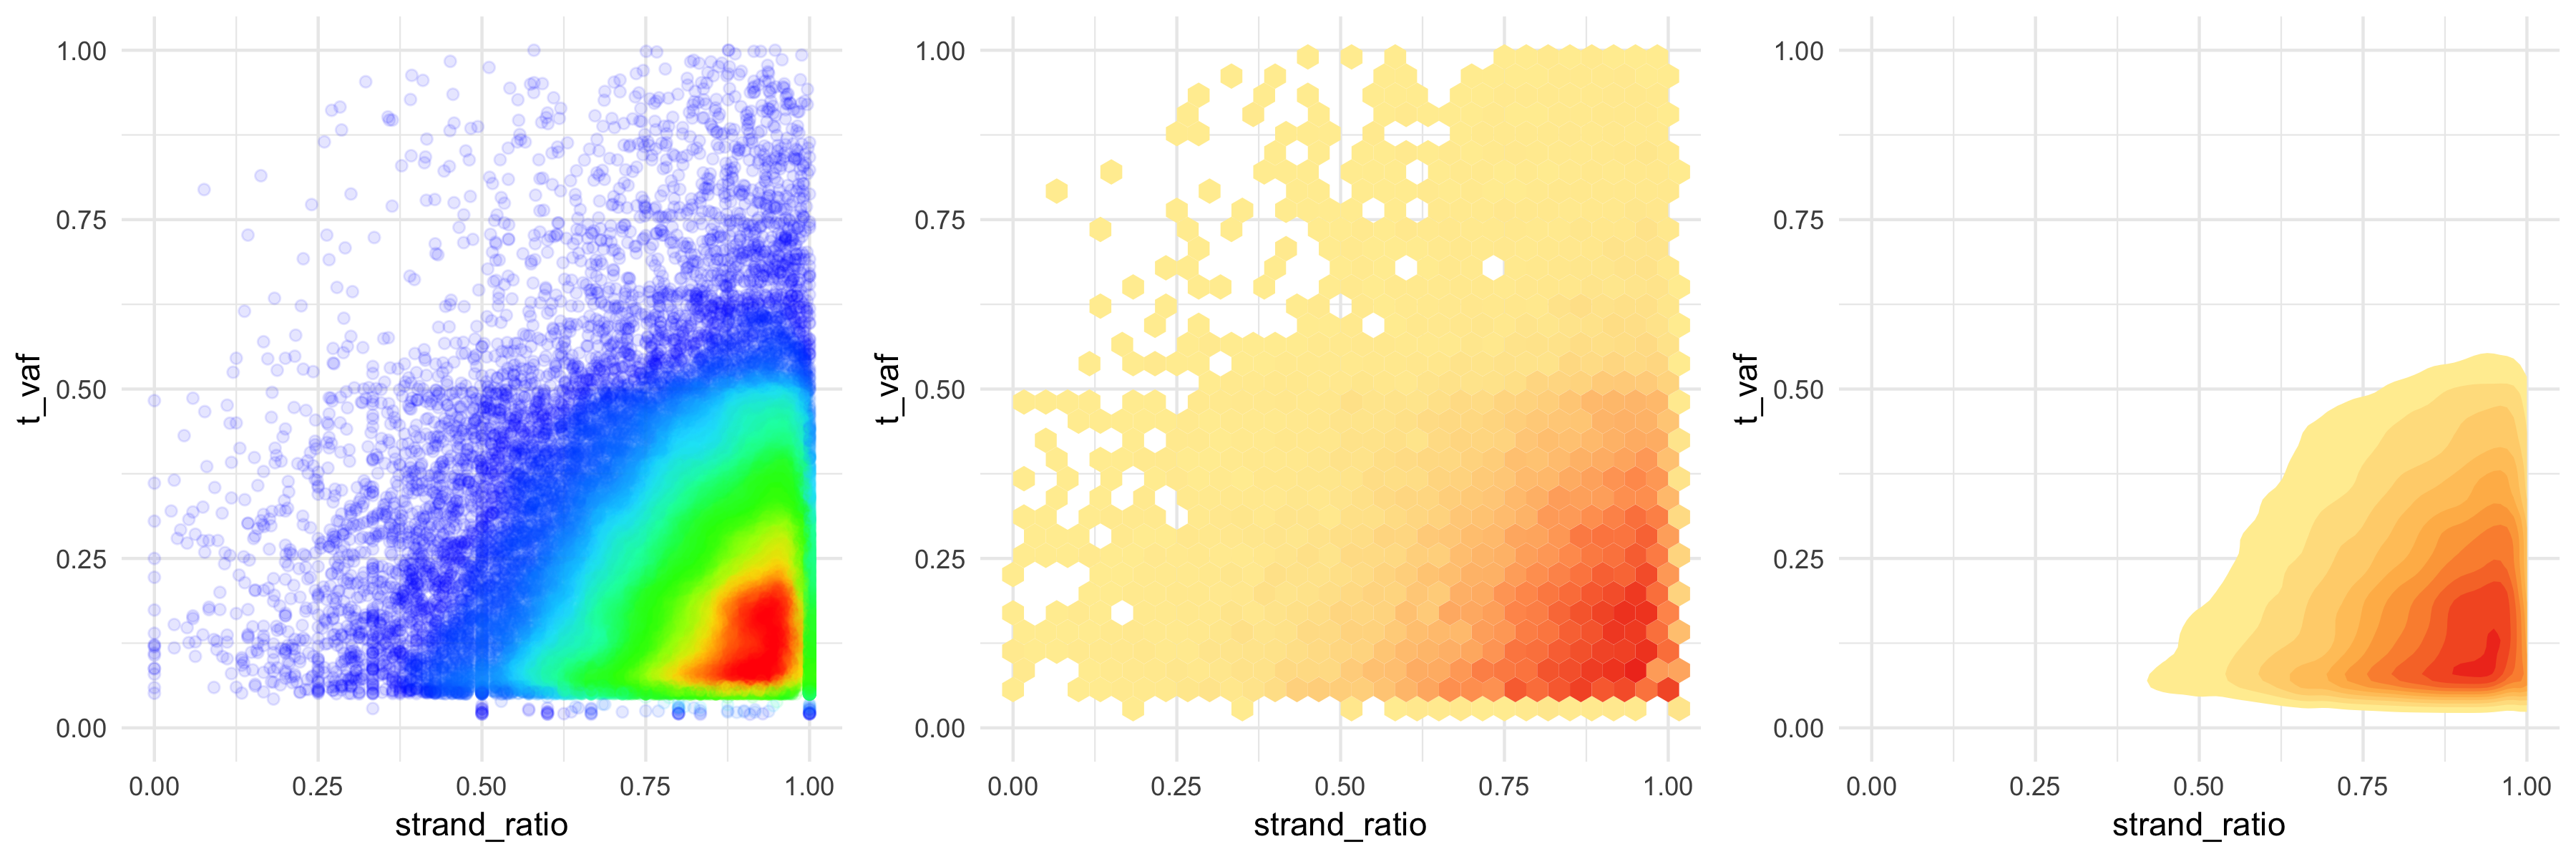

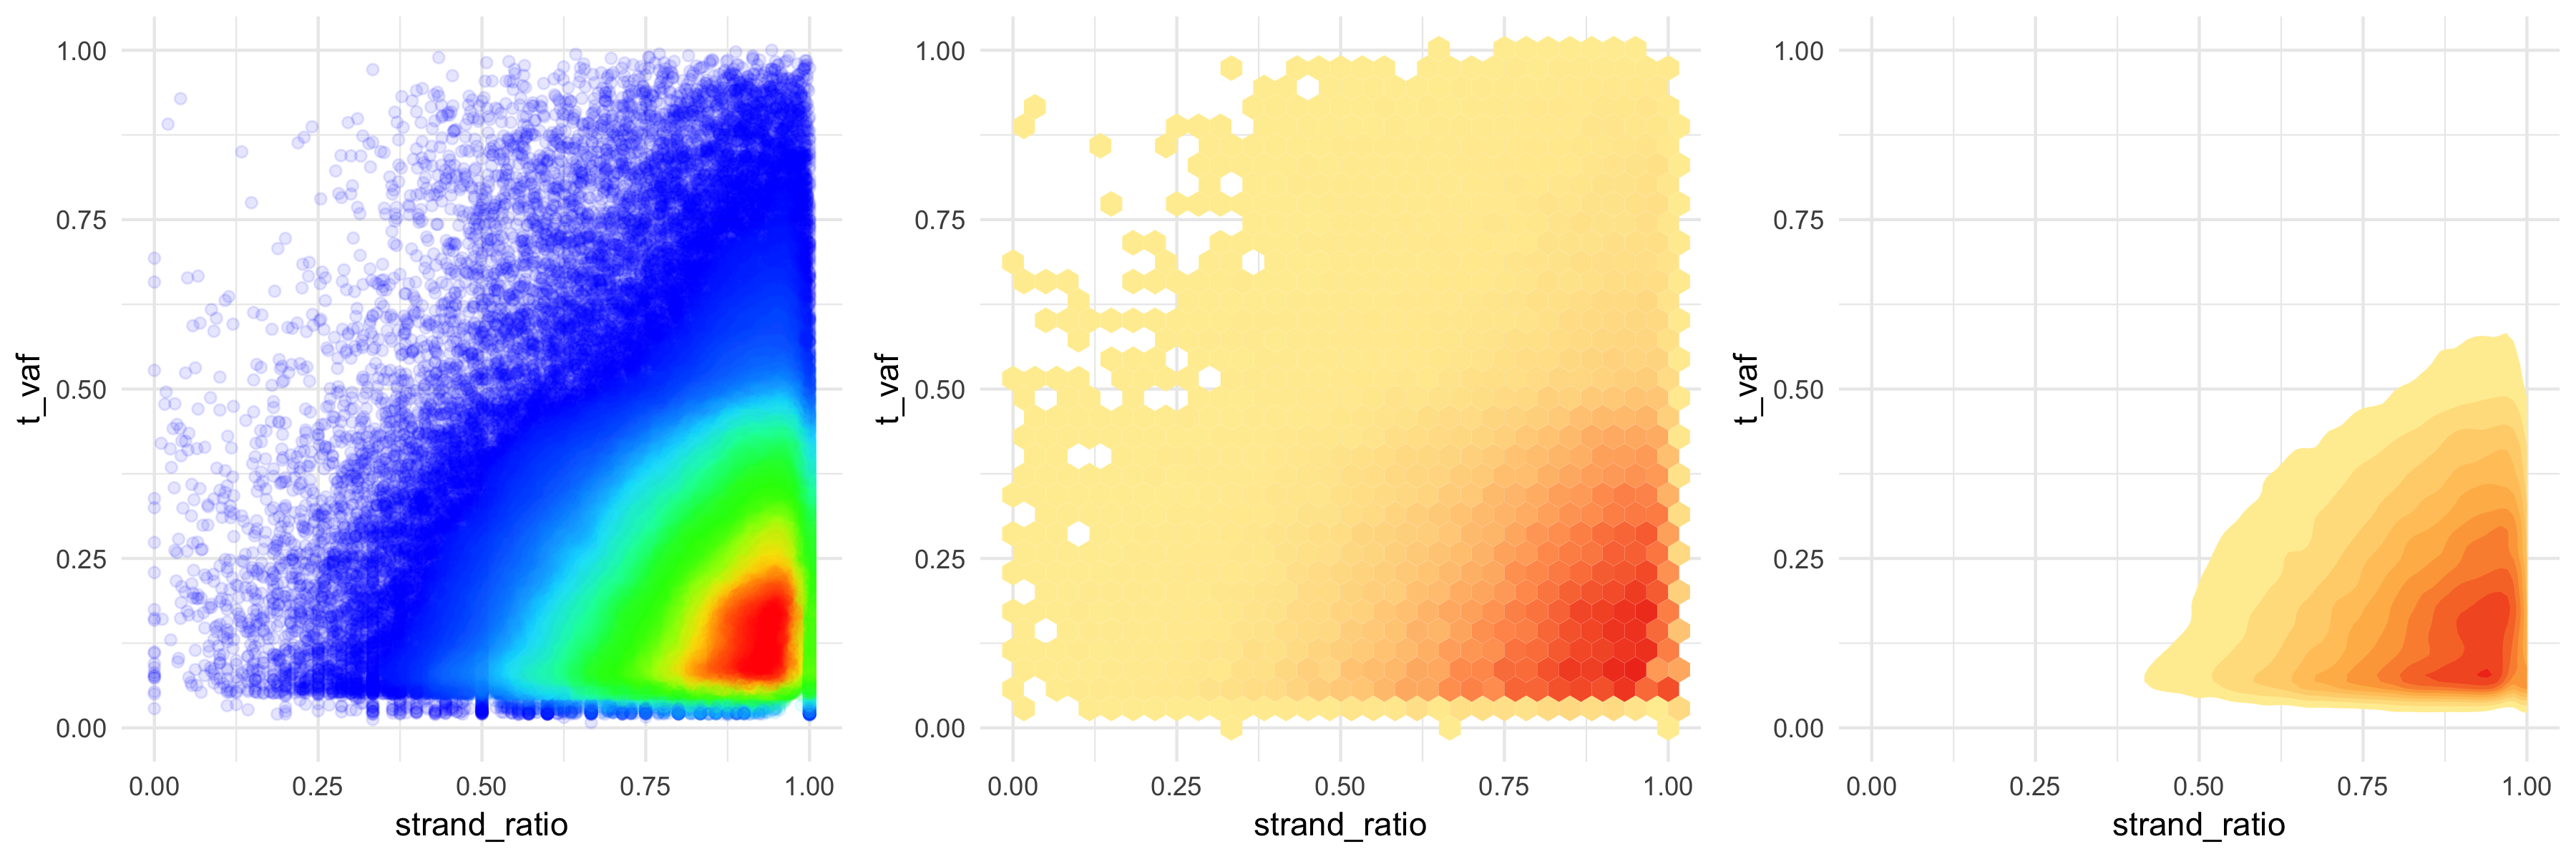

In [8]:
plot_density_2d(impact[impact$type == "synonymous",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))
plot_density_2d(impact[impact$type == "coding_somatic",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))

### Comparison of `Kaviar_AF`

Distribution of `Kaviar_AF` for the coding vs synonymous `type` (warning this is a sqrt x and sqrt y scale and this plot concerns only the non-null `Kaviar_AF` ie 26.64% of the data):

[1] "63157 over 237073 (26.64%)"

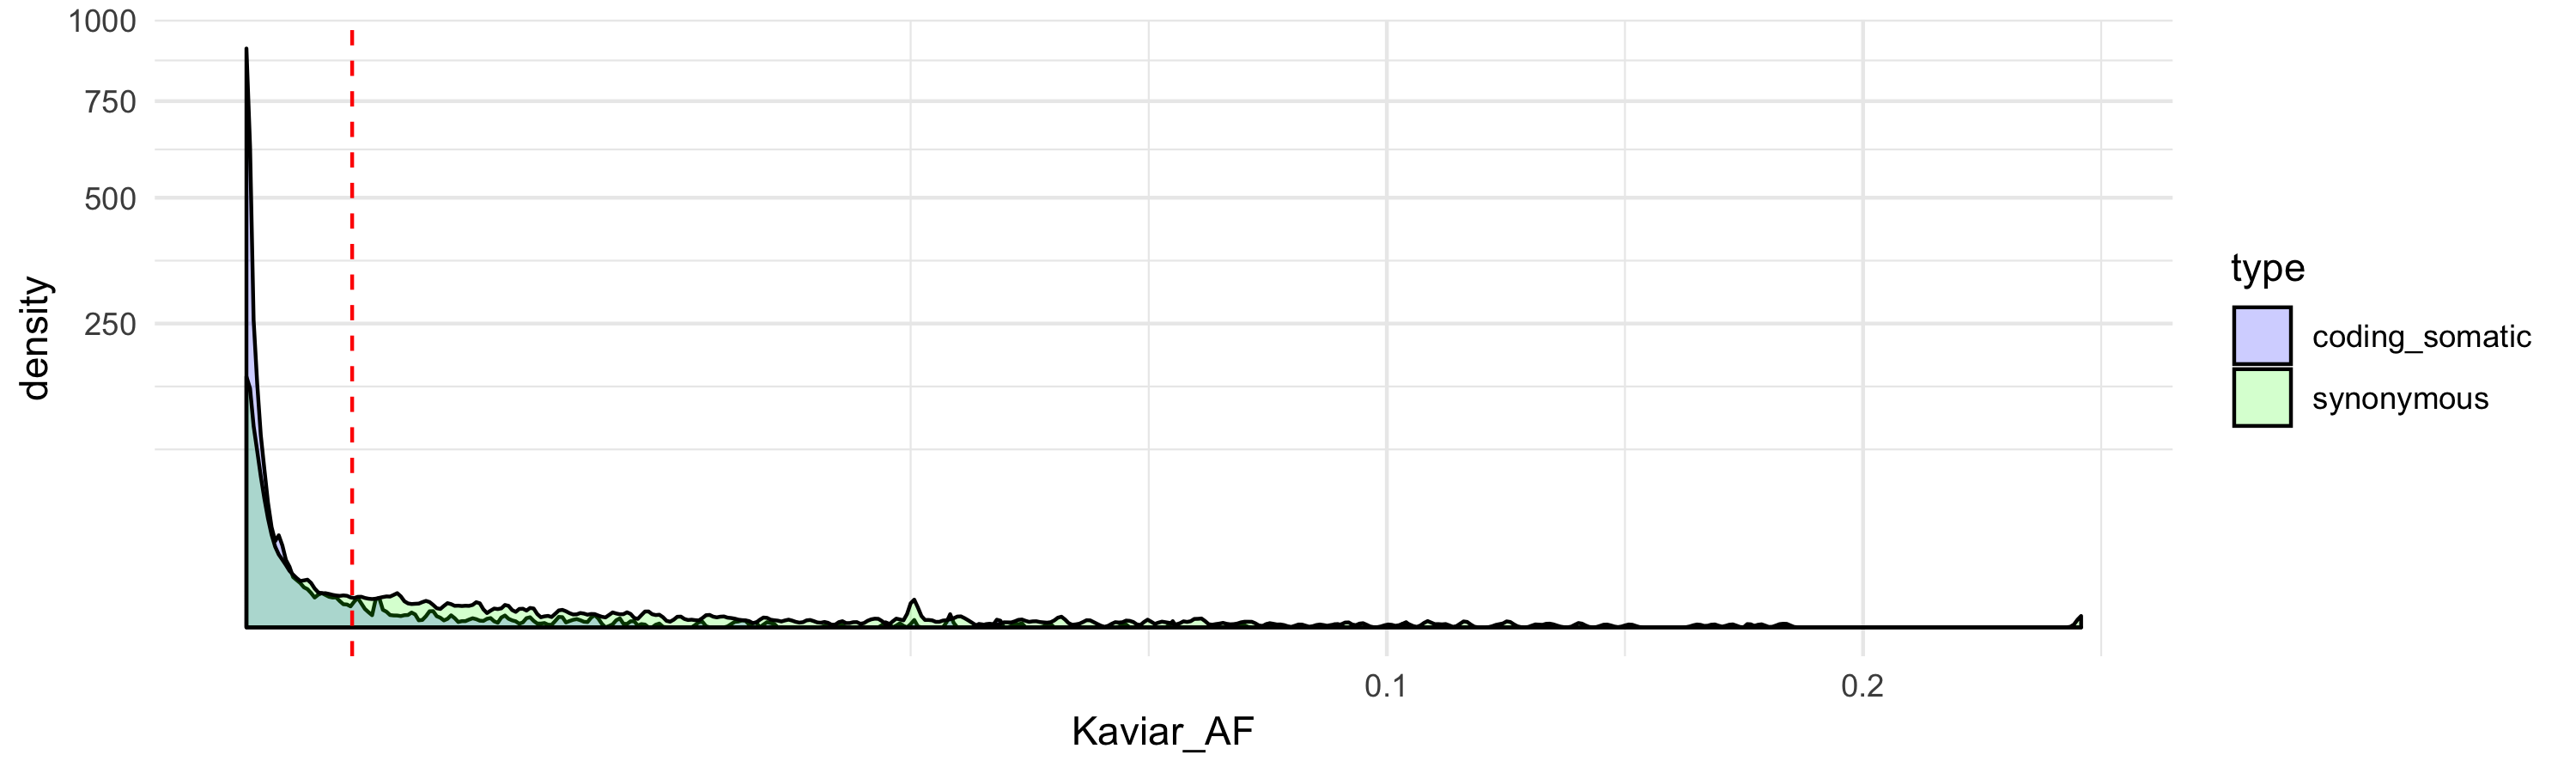

In [9]:
print_count_and_proportion(nrow(impact[impact$Kaviar_AF != 0,]), nrow(impact))
plot_density(impact[impact$Kaviar_AF != 0,], "Kaviar_AF", "type", lines = 0.001) + scale_x_sqrt() + scale_y_sqrt()

The synonymous mutations present a heavier `Kaviar_AF` tail, which are likely to be the artefacts call.

In [10]:
summary(impact[impact$type == "coding_somatic",]$Kaviar_AF)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 0.000e+00 2.594e-05 0.000e+00 1.730e-01 

In [11]:
summary(impact[impact$type == "synonymous",]$Kaviar_AF)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0005997 0.0000065 0.2572410 

In [12]:
100 * nrow(impact[impact$type == "coding_somatic" &
                  impact$Kaviar_AF > 0.001,]) / nrow(impact[impact$type == "coding_somatic",])
100 * nrow(impact[impact$type == "synonymous" &
                  impact$Kaviar_AF > 0.001,]) / nrow(impact[impact$type == "synonymous",])

[1] 0.2747664

[1] 4.173583

We are going to set a threshold on the `Kaviar_AF` parameter to try to curate the `synonymous` mutations, even if the threshold is a bit severe and will loose some somatic synonymous, we should still be able to work on a sufficient amount of `synonymous` mutations. The threshold will be set at 0.001 (see red line on the plot above).

In [13]:
impact <- impact[impact$type != "synonymous" |
                 (impact$type == "synonymous" & impact$Kaviar_AF <= 0.001),]

### Comparison of `cosmic_count`

Distribution of `cosmic_count` for the coding vs synonymous `albel` (warning this is a sqrt x and sqrt y scale and this plot concerns only the non-null `cosmic_count` ie 21,88% of the data):

[1] "51598 over 234986 (21.96%)"

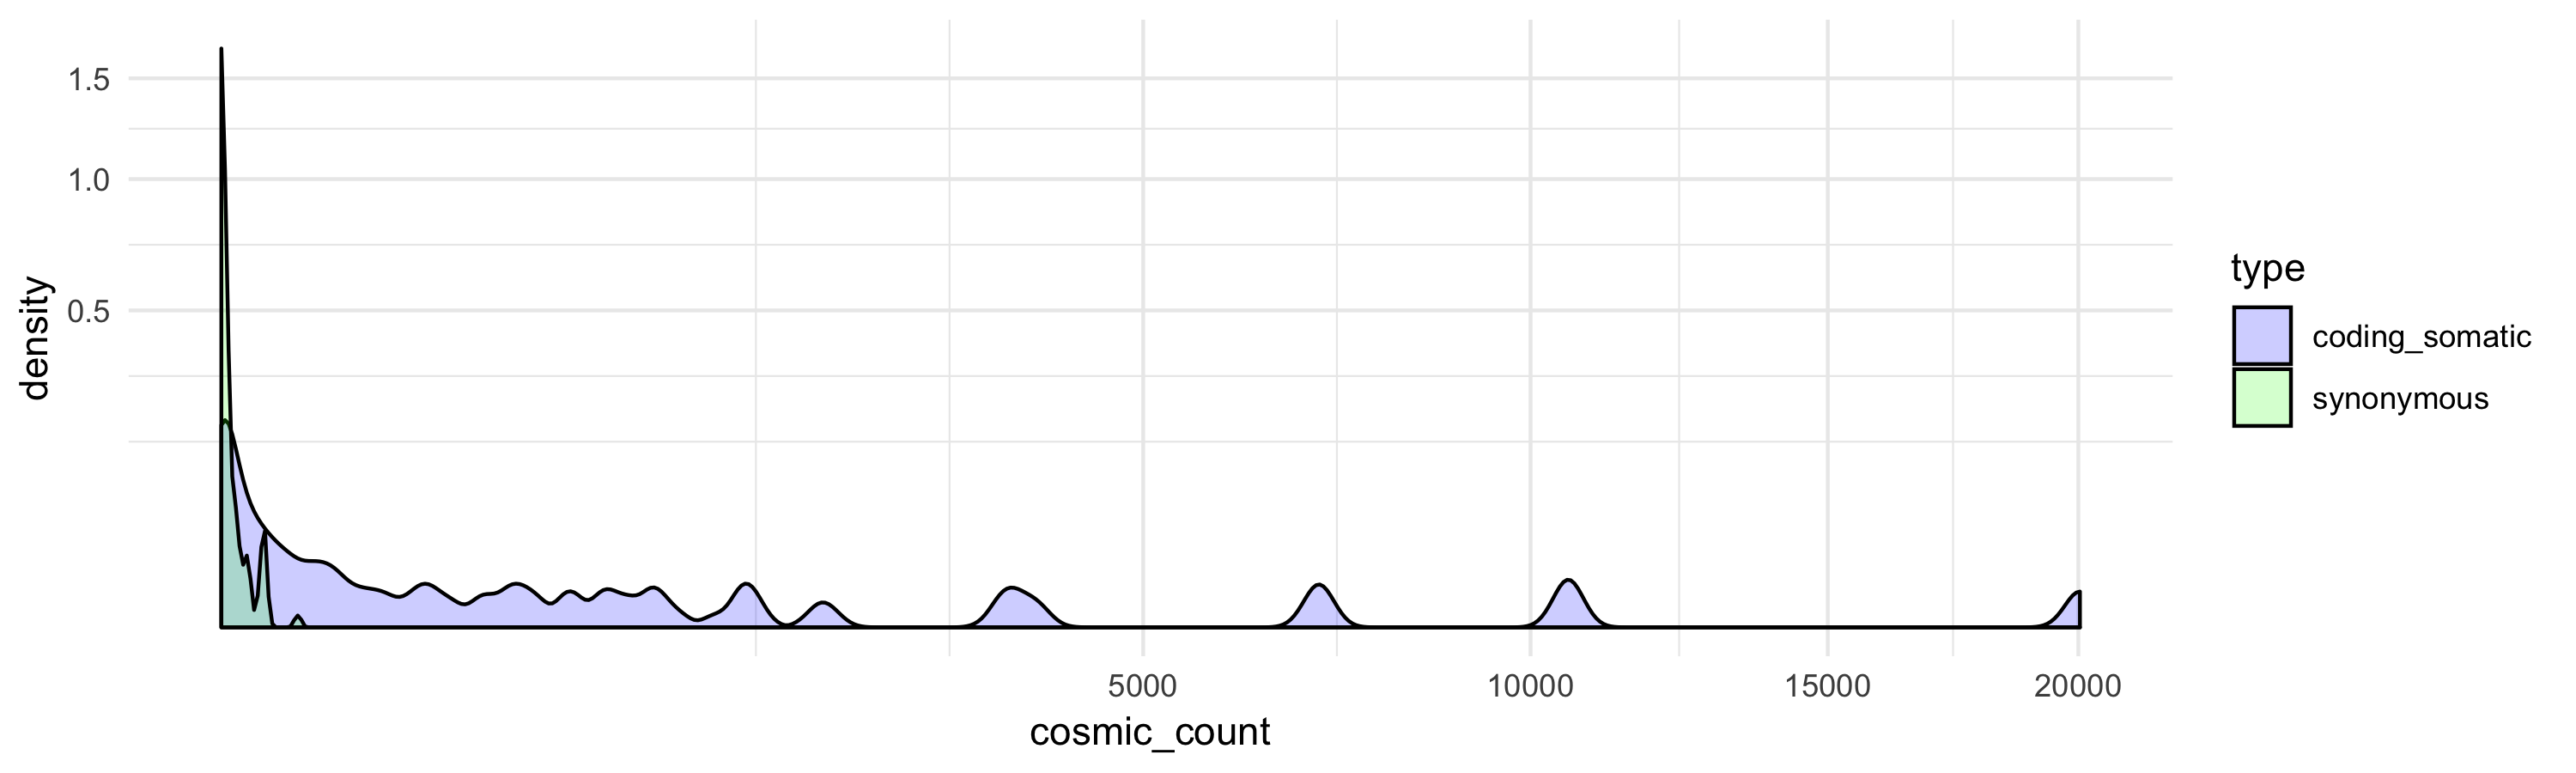

In [14]:
print_count_and_proportion(nrow(impact[impact$cosmic_count != 0,]), nrow(impact))
plot_density(impact[impact$cosmic_count != 0,], "cosmic_count", "type") + scale_x_sqrt() + scale_y_sqrt()

As expected the `synonymous` mutations have a really low `cosmic_count`.

In [15]:
summary(impact[impact$type == "synonymous",]$cosmic_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1262  0.0000 46.0000 

However, some of the synonymous mutations have an unexpectedly high `cosmic_count`:

In [16]:
impact[impact$type == "synonymous",] %>% group_by(mut_key) %>%
                                          filter(cosmic_count > 10) %>%
                                          summarise(cosmic_count = unique(cosmic_count),
                                                    Hugo_Symbol = unique(Hugo_Symbol),
                                                    HGVSp_Short = unique(HGVSp_Short),
                                                    frequency_in_normals = mean(frequency_in_normals),
                                                    Kaviar_AF = unique(Kaviar_AF)) %>%
                                          arrange(-cosmic_count)

mut_key         cosmic_count Hugo_Symbol HGVSp_Short frequency_in_normals
1 22_29091841_G_A 46           CHEK2       p.S372S     0                   
2 17_7579312_C_T  18           TP53        p.T125T     0                   
3 17_7579312_C_A  17           TP53        p.T125T     0                   
  Kaviar_AF
1 6.5e-06  
2 6.5e-06  
3 6.5e-06

* CHEK2 (`22_29091841_G_A`) has been [removed from COSMIC](https://cancer.sanger.ac.uk/cosmic/gene/analysis?all_data=&coords=AA%3AAA&dr=&gd=&id=407&ln=CHEK2&res_type=AA&seqlen=544&export=html&start=360&end=384)
* We will study the two TP53 mutations later

## The `mut_key` feature: study of reccurent mutations

In [17]:
impact_syn <- impact[impact$typw == "synonymous",] # keep only the synonymous mutations

Each mutations is identified by a unique key `mut_key` : `Chromosome`_`Start_Position`_`Reference_Allele`_`Tumor_Seq_Allele2`. The mutations sharing the same key are the same.

In [18]:
head(impact_syn$mut_key)
length(unique(impact_syn$mut_key)) # number of different keys e.g. number of different mutations

character(0)

[1] 0

### Identify the reccurent mutations

We need to study the reccurence of mutations taking care not to consider a mutation as recurrent if it comes frome the same patient. To do so we will group the rows by patient, and select only the distinct mutations for each patient:

In [19]:
# create a patient id (no problem will be caused by 'None-T01-IM6' which will become 'None-T01-')
impact_syn$patient_id <- substr(impact_syn$Tumor_Sample_Barcode, 1, 9)
head(unique(impact_syn$patient_id))

character(0)

In [20]:
impact_unique_mut_keys_per_patient <- as.data.frame(impact_syn %>% group_by(patient_id) %>%
                                                                   select(patient_id, mut_key, Hugo_Symbol) %>%
                                                                   filter(! duplicated(mut_key)))
nrow(impact_syn)
nrow(impact_unique_mut_keys_per_patient)

[1] 0

[1] 0

In [21]:
mut_key_info <- as.data.frame(impact_unique_mut_keys_per_patient %>% group_by(mut_key) %>%
                                                                     summarise(count = n(),
                                                                               Hugo_Symbol = unique(Hugo_Symbol)))
head(mut_key_info)

mut_key count Hugo_Symbol

In [22]:
for (threshold in c(2, 3, 5, 10)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$count >= threshold,]
    
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples [%2.0f%% (%5d) of the rows concerned]",
                  100 * nrow(mut_key_info_threshold) / nrow(mut_key_info),
                  nrow(mut_key_info_threshold),
                  threshold,
                  100 * nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,]) / nrow(impact_unique_mut_keys_per_patient),
                  nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,])))
}

[1] "NaN% (    0) of the keys are shared by at least  2 samples [NaN% (    0) of the rows concerned]"
[1] "NaN% (    0) of the keys are shared by at least  3 samples [NaN% (    0) of the rows concerned]"
[1] "NaN% (    0) of the keys are shared by at least  5 samples [NaN% (    0) of the rows concerned]"
[1] "NaN% (    0) of the keys are shared by at least 10 samples [NaN% (    0) of the rows concerned]"


Distribution of the mutations key count for the mutations present in at least 2 samples (warning this is a sqrt x and y scale):

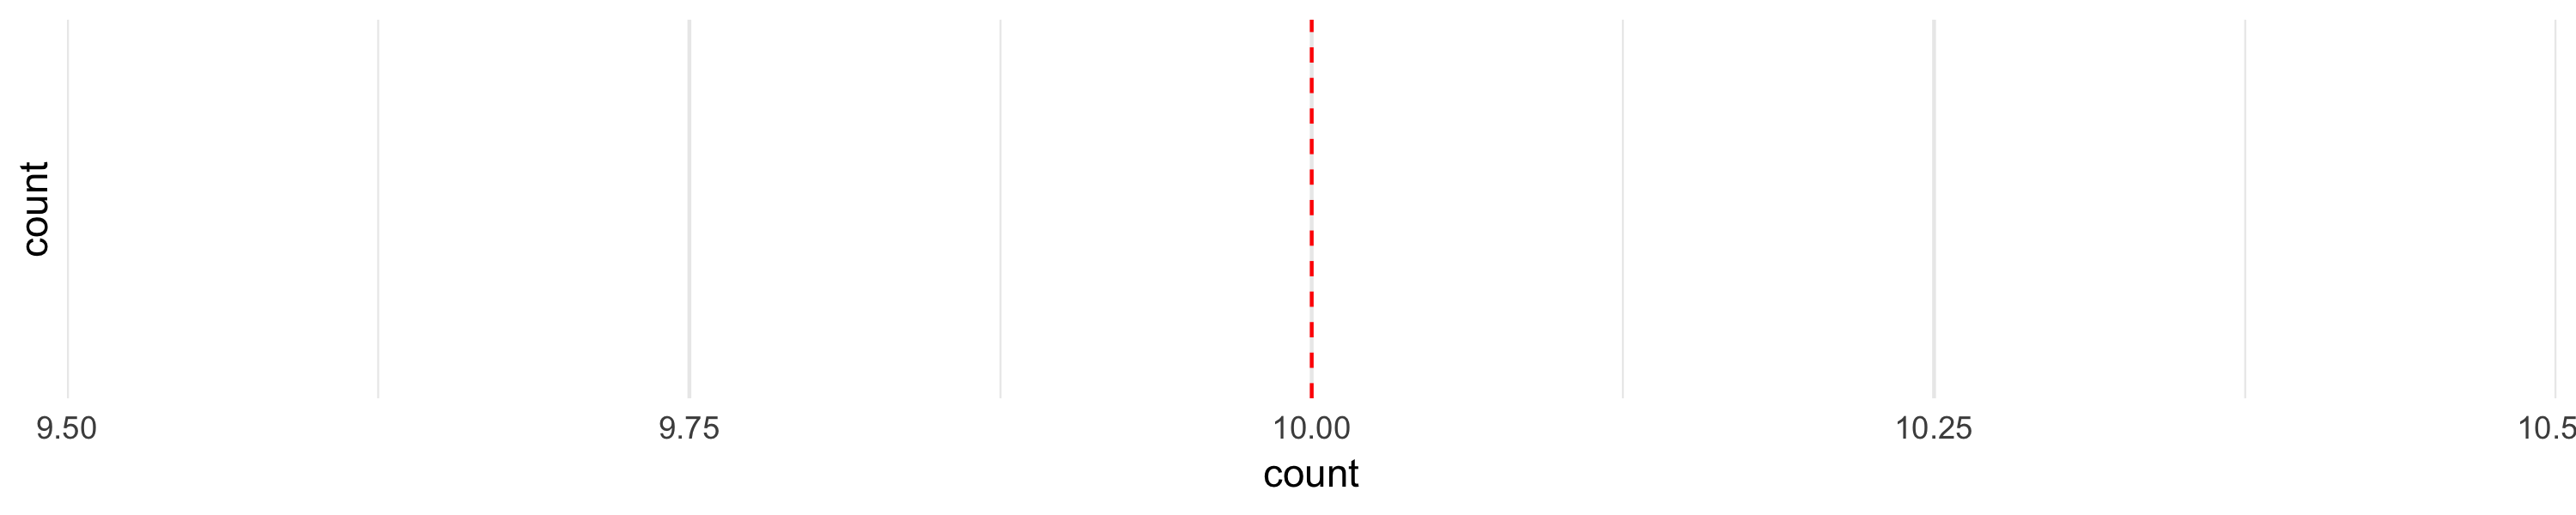

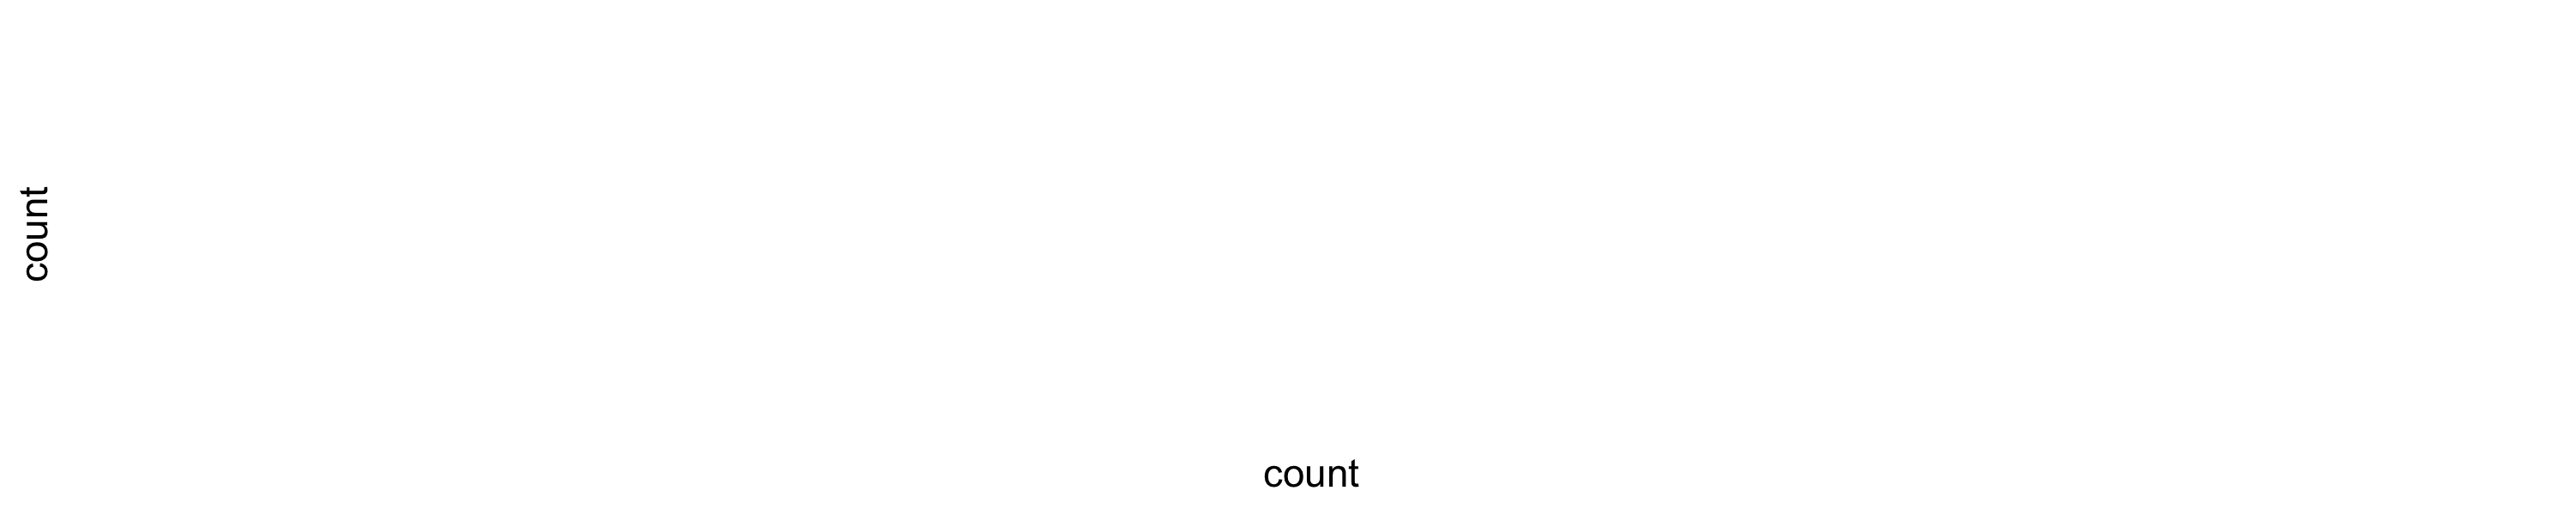

In [23]:
repeated_key <- mut_key_info[mut_key_info$count >= 2,] # keys shared by at least 2 samples
notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(x = count)) + geom_vline(aes_(xintercept = 10), linetype = "dashed", color = "red")
ggplot(repeated_key[repeated_key$count >= 10,]) + geom_bar(aes(x = count))

### Sudy the reccurent mutations genes

In [24]:
length(unique(repeated_key$Hugo_Symbol))

[1] 0

In [25]:
head(repeated_key)

mut_key count Hugo_Symbol

Here is a plot of the genes that are the most mutated **accross the mutation keys**:

ERROR: Error in names(x) <- value: 'names' attribute [2] must be the same length as the vector [1]


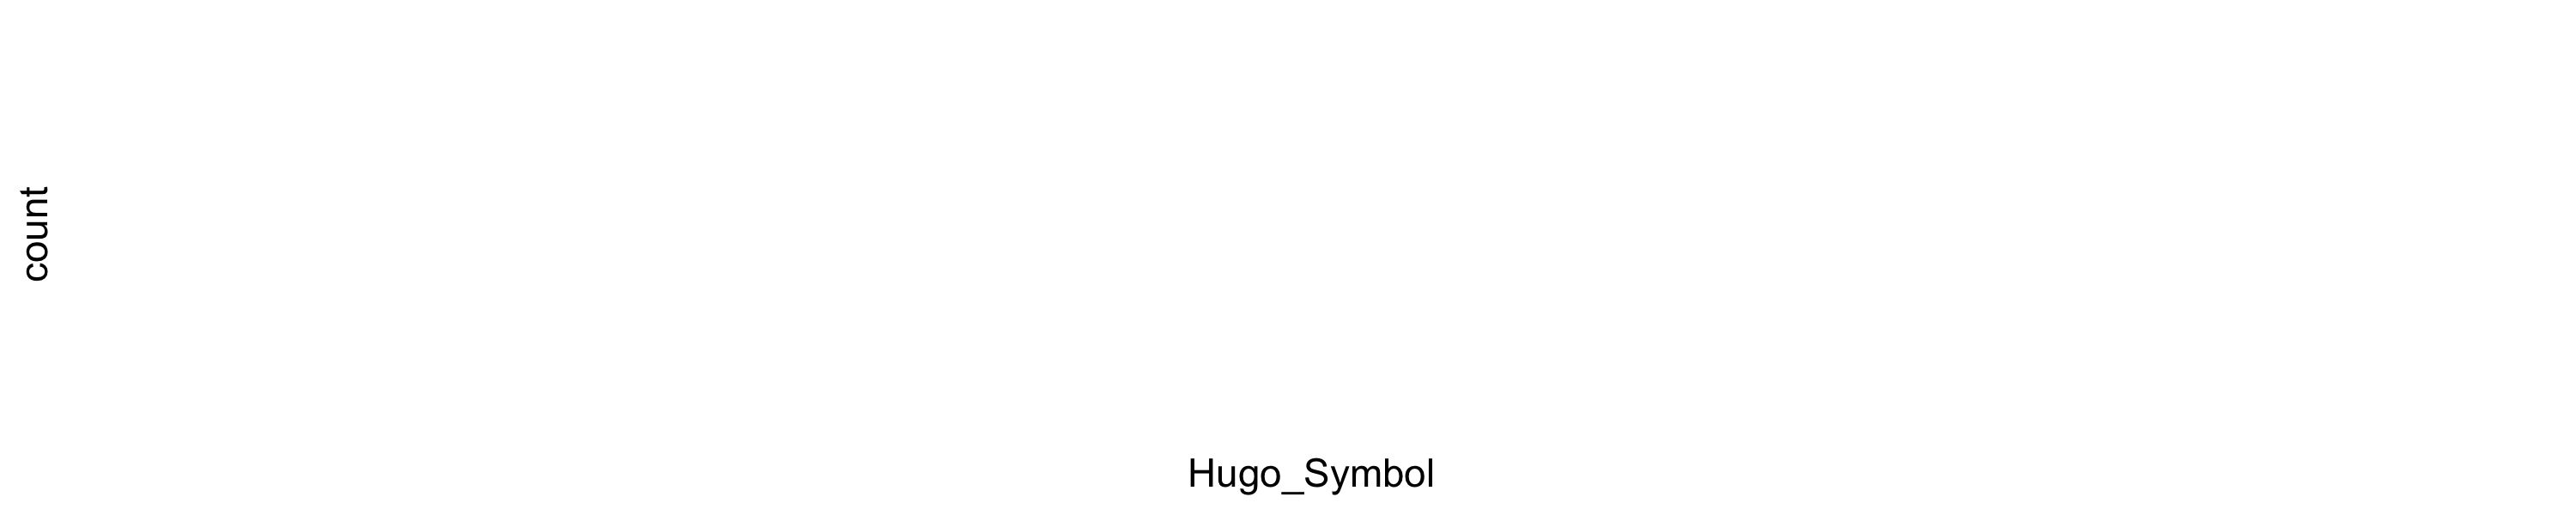

In [26]:
repeated_key <- sort_histogram(repeated_key, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(repeated_key, "Hugo_Symbol", 20) + tilt_x_label_45()

Here is a plot of the genes that are the most mutated **accross the rows**:

In [ ]:
rec_impact <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% repeated_key$mut_key,]

rec_impact <- sort_histogram(rec_impact, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(rec_impact) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(rec_impact, "Hugo_Symbol", 20) + tilt_x_label_45()

### Study the outliers

Let's study the outliers present in more than 20 samples:

In [ ]:
outliers <- repeated_key %>% filter(count >= 20) %>%
                             arrange(-count) %>%
                             mutate(rank = row_number()) %>%
                             select(rank, count, mut_key, Hugo_Symbol)
        
outliers

We will study in order:
* The rows 1 (AR), 10 (ATRX) and 13 (AR1D1B)
* The rows 2 and 3 (TP53)
* The remaining rows (SDHA)

See later for use of the following function:

In [ ]:
get_mutation_info <- function(data, mutation_key, cosmic_and_gnomad = TRUE, plots = FALSE) {
    selected_rows <- data[data$mut_key == mutation_key,]
    
    mutation <- selected_rows %>% summarise(count = n(),
                                            mut_key = unique(mut_key),
                                            Hugo_Symbol = unique(Hugo_Symbol),
                                            Chromosome = unique(Chromosome),
                                            cDNA_change = toString(unique(cDNA_change)),
                                            HGVSp_Short = toString(unique(HGVSp_Short)),
                                            Kaviar_AF = unique(Kaviar_AF),
                                            cosmic_count = unique(cosmic_count))
    
    if (cosmic_and_gnomad) {
        print(paste0("gnomAD link: http://gnomad.broadinstitute.org/variant/",
                     gsub('_', '-', mutation_key), " "))
        print(paste0("COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=",
                     mutation$Hugo_Symbol, "+", mutation$HGVSp_Short, " "))
    }
    
    if (plots) {
        
        data$name <- "0_all dataset"
        data[data$mut_key == mutation_key,]$name <- mutation_key
    
        plot1 <- plot_density(data, "t_vaf", fill = "name", height = 2, adjust = 1/3) + theme(legend.position = "none")
        
        if (any(selected_rows$frequency_in_normals != 0)) {
            plot2 <- plot_density(data[data$frequency_in_normals != 0,], "frequency_in_normals", fill = "name", height = 2, adjust = 1/3)        }
        else
            plot2 <- ggplot() + annotate("text", x = 1, y = 1, label = "frequency_in_normals = 0") +
                                theme(text = element_blank())
        
        plot_side_by_side(plot1, plot2, height = 1.5)
    }
    
    return (mutation)
}

#### Row 1 (AR), 10 (ATRX) and 13 (AR1DB1)

** Row 1: AR (`X_66766359_C_T`)**

In [ ]:
get_mutation_info(impact_syn, outliers$mut_key[1], plots = TRUE)

`t_vaf`$\approx$`0.5` and high `frequency_in_normals`, `Kaviar_AF` not null, and exists in gnomAD (allele frequency of 3.9%): probably germline.

** Row 10: ATRX (`X_76907799_T_C`) <font color='blue'> → further study needed </font>**

In [ ]:
get_mutation_info(impact_syn, outliers$mut_key[10], plots = TRUE)
print("frequency_in_normals:")
print(impact_syn$frequency_in_normals[impact_syn$mut_key == outliers$mut_key[10]])

In [ ]:
summary(impact$strand_ratio[impact$mut_key == outliers$mut_key[10]])

Not in COSMIC nor in gnomAD.

**Row 13: AR1DB1 (`6_157099426_A_G`)**

In [ ]:
get_mutation_info(impact_syn, outliers$mut_key[13], plots = TRUE)

High `frequency_in_normals`, `Kaviar_AF` not null, and exists in gnomAD (allele frequency of 0.4%): probably germline.

#### Rows 2 and 3 (TP53)  <font color='blue'> → further study needed </font>

* These two synonymous mutations are acting on the same 3-bp
* The `HGVSp_Short` concerned is `p.T125T`
* They concern 66 different patients
* They both exist in COSMIC
* The both have a null gnomAD and `frequency_in_normals`
* The third variant (`c.375G>C`) appears 5 times in the database

In [ ]:
length(unique(impact_syn$patient_id[impact_syn$mut_key %in% outliers$mut_key[outliers$Hugo_Symbol == "TP53"]]))

In [ ]:
get_mutation_info(impact_syn, outliers$mut_key[2], plots = TRUE)

In [ ]:
get_mutation_info(impact_syn, outliers$mut_key[3], plots = TRUE)

In [ ]:
impact[impact$Hugo_Symbol == "TP53" & impact$cDNA_change == "c.375G>C",]

#### Outliers in `SDHA`  <font color='blue'> → further study needed </font>

* These 8 synonymous mutations are acting on the same domain (`p.V395V`, `p.T396T`, `p.P401P`, `p.V402V`, `p.L403L`, `p.P404P`, `p.H407H`, `p.Y408Y`)
* 2 of them appear in COSMIC with a low cosmic count:
    * https://cancer.sanger.ac.uk/cosmic/search?q=SDHA+p.P404P cosmic count = 1
    * https://cancer.sanger.ac.uk/cosmic/search?q=SDHA+p.T396T cosmic count = 2
* They all have a null gnomAD and `frequency_in_normals` (except for one, `5_235400_C_T` having a really low gnomAD score 0.000004061 and a low `frequency_in_normals`)
* They concern 24 different patients, almost all having each of the 8 mutations with a similar vaf (see plots under)

24 patients are concerned with these 8 high reccurences in `SDHA`:

In [ ]:
patients_concerned <- unique(impact_syn$patient_id[impact_syn$mut_key %in% outliers$mut_key[outliers$Hugo_Symbol == "SDHA"]])
length(patients_concerned)
patients_concerned

These patients do not have any other mutation in this gene (except 2 for 2 different patients):

In [ ]:
impact$patient_id <- substr(impact$Tumor_Sample_Barcode, 1, 9)

impact[impact$patient_id %in% patients_concerned &
       impact$Hugo_Symbol == "SDHA" &
       ! impact$mut_key %in% outliers$mut_key[outliers$Hugo_Symbol == "SDHA"],]

In [ ]:
dd <- data.frame()

for (id in outliers$rank[outliers$Hugo_Symbol == "SDHA"])
    dd <- rbind(dd, get_mutation_info(impact, outliers$mut_key[outliers$rank == id], cosmic_and_gnomad = FALSE,
                                      plots = FALSE))
dd

In [ ]:
for (id in outliers$rank[outliers$Hugo_Symbol == "SDHA"])
    get_mutation_info(impact, outliers$mut_key[outliers$rank == id], cosmic_and_gnomad = TRUE, plots = FALSE)

In [ ]:
for (id in outliers$rank[outliers$Hugo_Symbol == "SDHA"])
    get_mutation_info(impact, outliers$mut_key[outliers$rank == id], cosmic_and_gnomad = FALSE, plots = TRUE)

In [ ]:
get_simple_table(impact$Hugo_Symbol[impact$patient_id %in% patients_concerned], min = 5)

In [ ]:
impact <- add_features("../../../data/", impact, oncokb = TRUE)

In [ ]:
get_simple_table(impact$oncogenic[impact$patient_id %in% patients_concerned])

In [ ]:
outliers <- repeated_key %>% filter(count >= 10 & count < 20) %>%
                             arrange(-count) %>%
                             mutate(rank = row_number()) %>%
                             select(rank, count, mut_key, Hugo_Symbol)
        
outliers

#### Next outliers

Let's study the outliers present between 10 and 20 samples:

In [ ]:
outliers <- repeated_key %>% filter(count >= 10 & count < 20) %>%
                             arrange(-count) %>%
                             mutate(rank = row_number()) %>%
                             select(rank, count, mut_key, Hugo_Symbol)
        
outliers

We will study in order:
* The rows 1 (AR), 10 (ATRX) and 13 (AR1D1B)
* The rows 2 and 3 (TP53)
* The remaining rows (SDHA)

In [ ]:
for (rank in seq(1, 3))
    get_mutation_info(impact_syn, outliers$mut_key[rank])